# CDS503 Lab 2: KNN (Julia)

In [1]:
using DataFrames
using CSV
# using XLSX
using Plots
using Statistics
using LinearAlgebra
using StatsPlots

using Random

using MLLabelUtils  # label encoding
using MLDataUtils   # splitobs, getobs

using ScikitLearn
using ScikitLearn: fit!, predict
using ScikitLearn.CrossValidation: train_test_split

using PyCall

@sk_import neighbors: KNeighborsClassifier
@sk_import metrics: accuracy_score
# @sk_import datasets: (make_moons, make_circles, make_classification)

PyObject <function accuracy_score at 0x00000000612843A8>

In [2]:
df = CSV.read("..//data//titanic.csv", copycols=true);
show(first(df, 5), allcols=true)

5×8 DataFrame
│ Row │ Survived │ Pclass │ Name                                               │
│     │ Int64    │ Int64  │ String                                             │
├─────┼──────────┼────────┼────────────────────────────────────────────────────┤
│ 1   │ 0        │ 3      │ Mr. Owen Harris Braund                             │
│ 2   │ 1        │ 1      │ Mrs. John Bradley (Florence Briggs Thayer) Cumings │
│ 3   │ 1        │ 3      │ Miss. Laina Heikkinen                              │
│ 4   │ 1        │ 1      │ Mrs. Jacques Heath (Lily May Peel) Futrelle        │
│ 5   │ 0        │ 3      │ Mr. William Henry Allen                            │

│ Row │ Sex    │ Age     │ Siblings/Spouses Aboard │ Parents/Children Aboard │
│     │ String │ Float64 │ Int64                   │ Int64                   │
├─────┼────────┼─────────┼─────────────────────────┼─────────────────────────┤
│ 1   │ male   │ 22.0    │ 1                       │ 0                       │
│ 2   │ female │ 38.0

In [3]:
size(df)

(887, 8)

In [4]:
oldnames = names(df)
newnames = [
    :survived,
    :pclass,
    :name,
    :sex,
    :age,
    :siblingsspouses,
    :parentschildren,
    :fare
]

rename!(df, [ oldnames[i] => newnames[i] for i in 1:length(newnames) ])

show(first(df, 5), allcols=true)

5×8 DataFrame
│ Row │ survived │ pclass │ name                                               │
│     │ Int64    │ Int64  │ String                                             │
├─────┼──────────┼────────┼────────────────────────────────────────────────────┤
│ 1   │ 0        │ 3      │ Mr. Owen Harris Braund                             │
│ 2   │ 1        │ 1      │ Mrs. John Bradley (Florence Briggs Thayer) Cumings │
│ 3   │ 1        │ 3      │ Miss. Laina Heikkinen                              │
│ 4   │ 1        │ 1      │ Mrs. Jacques Heath (Lily May Peel) Futrelle        │
│ 5   │ 0        │ 3      │ Mr. William Henry Allen                            │

│ Row │ sex    │ age     │ siblingsspouses │ parentschildren │ fare    │
│     │ String │ Float64 │ Int64           │ Int64           │ Float64 │
├─────┼────────┼─────────┼─────────────────┼─────────────────┼─────────┤
│ 1   │ male   │ 22.0    │ 1               │ 0               │ 7.25    │
│ 2   │ female │ 38.0    │ 1               │ 

In [5]:
# Drop column: name
select!(df, Not(:name))
show(first(df, 5), allcols=true)

5×7 DataFrame
│ Row │ survived │ pclass │ sex    │ age     │ siblingsspouses │
│     │ Int64    │ Int64  │ String │ Float64 │ Int64           │
├─────┼──────────┼────────┼────────┼─────────┼─────────────────┤
│ 1   │ 0        │ 3      │ male   │ 22.0    │ 1               │
│ 2   │ 1        │ 1      │ female │ 38.0    │ 1               │
│ 3   │ 1        │ 3      │ female │ 26.0    │ 0               │
│ 4   │ 1        │ 1      │ female │ 35.0    │ 1               │
│ 5   │ 0        │ 3      │ male   │ 35.0    │ 0               │

│ Row │ parentschildren │ fare    │
│     │ Int64           │ Float64 │
├─────┼─────────────────┼─────────┤
│ 1   │ 0               │ 7.25    │
│ 2   │ 0               │ 71.2833 │
│ 3   │ 0               │ 7.925   │
│ 4   │ 0               │ 53.1    │
│ 5   │ 0               │ 8.05    │

In [6]:
# Print column names
names(df)

7-element Array{Symbol,1}:
 :survived
 :pclass
 :sex
 :age
 :siblingsspouses
 :parentschildren
 :fare

In [7]:
# Print data type of each column
for col in names(df)
    coltype = eltype(df[!, col])
    println("$col: $coltype")
end

survived: Int64
pclass: Int64
sex: String
age: Float64
siblingsspouses: Int64
parentschildren: Int64
fare: Float64


In [8]:
# Convert attribute: survived from Int64 to String
df[!, :survived] = string.(df[!, :survived])
show(first(df, 5), allcols=true)

5×7 DataFrame
│ Row │ survived │ pclass │ sex    │ age     │ siblingsspouses │
│     │ String   │ Int64  │ String │ Float64 │ Int64           │
├─────┼──────────┼────────┼────────┼─────────┼─────────────────┤
│ 1   │ 0        │ 3      │ male   │ 22.0    │ 1               │
│ 2   │ 1        │ 1      │ female │ 38.0    │ 1               │
│ 3   │ 1        │ 3      │ female │ 26.0    │ 0               │
│ 4   │ 1        │ 1      │ female │ 35.0    │ 1               │
│ 5   │ 0        │ 3      │ male   │ 35.0    │ 0               │

│ Row │ parentschildren │ fare    │
│     │ Int64           │ Float64 │
├─────┼─────────────────┼─────────┤
│ 1   │ 0               │ 7.25    │
│ 2   │ 0               │ 71.2833 │
│ 3   │ 0               │ 7.925   │
│ 4   │ 0               │ 53.1    │
│ 5   │ 0               │ 8.05    │

In [9]:
# Check the distribution of the dataset
print(by(df, :survived, nrow))

# Comment: This dataset is not balanced.

2×2 DataFrame
│ Row │ survived │ x1    │
│     │ String   │ Int64 │
├─────┼──────────┼───────┤
│ 1   │ 0        │ 545   │
│ 2   │ 1        │ 342   │

In [10]:
# df[!, :pclass] = string.(df[!, :pclass])
# show(first(df, 5), allcols=true)

In [11]:
# using Pkg

# Pkg.add("MLLabelUtils")

In [12]:
# using MLLabelUtils

In [13]:
sexlabel = label(df[!, :sex])

2-element Array{String,1}:
 "male"
 "female"

In [14]:
# Label Encode sex
# sexlabel = ["male", "female"]

# 1 => "male"; 0 => "female"
sexlabelenc = [1, 0]

df[!, :sex] = convertlabel(
    sexlabelenc, 
    df[!, :sex], 
    LabelEnc.NativeLabels(sexlabel))

show(first(df, 5))

5×7 DataFrame. Omitted printing of 2 columns
│ Row │ survived │ pclass │ sex   │ age     │ siblingsspouses │
│     │ String   │ Int64  │ Int64 │ Float64 │ Int64           │
├─────┼──────────┼────────┼───────┼─────────┼─────────────────┤
│ 1   │ 0        │ 3      │ 1     │ 22.0    │ 1               │
│ 2   │ 1        │ 1      │ 0     │ 38.0    │ 1               │
│ 3   │ 1        │ 3      │ 0     │ 26.0    │ 0               │
│ 4   │ 1        │ 1      │ 0     │ 35.0    │ 1               │
│ 5   │ 0        │ 3      │ 1     │ 35.0    │ 0               │

In [15]:
# DEMO

labelmap(df[!, :sex])

Dict{Int64,Array{Int64,1}} with 2 entries:
  0 => [2, 3, 4, 9, 10, 11, 12, 15, 16, 19  …  863, 868, 871, 872, 876, 877, 87…
  1 => [1, 5, 6, 7, 8, 13, 14, 17, 18, 21  …  870, 873, 874, 875, 878, 880, 881…

## Train and Validate KNN Classifier

In [16]:
# Set target and feature attributes
target = df[!, :survived]
features = select(df, Not(:survived))

show(first(features, 5))

5×6 DataFrame
│ Row │ pclass │ sex   │ age     │ siblingsspouses │ parentschildren │ fare    │
│     │ Int64  │ Int64 │ Float64 │ Int64           │ Int64           │ Float64 │
├─────┼────────┼───────┼─────────┼─────────────────┼─────────────────┼─────────┤
│ 1   │ 3      │ 1     │ 22.0    │ 1               │ 0               │ 7.25    │
│ 2   │ 1      │ 0     │ 38.0    │ 1               │ 0               │ 71.2833 │
│ 3   │ 3      │ 0     │ 26.0    │ 0               │ 0               │ 7.925   │
│ 4   │ 1      │ 0     │ 35.0    │ 1               │ 0               │ 53.1    │
│ 5   │ 3      │ 1     │ 35.0    │ 0               │ 0               │ 8.05    │

In [17]:
# Random seet does not fix the shuffleobs, result always change
# #now split the data into training sets and validation sets
# Random.seed!(123)
# (features, target) = shuffleobs((features, target))
# (X_train1, y_train1), (X_test1, y_test1) = splitobs((features, target); at = 0.8)

In [18]:
# # Helper function to split the dataset - EXPERIMENTAL
# function shuffledf(df, seed, testsize)
#     Random.seed!(seed)
#     dfrandom = DataFrame()
    
#     if typeof(df) <: DataFrame
#         dfrandom = copy(df)        
#     elseif typeof(df) <: Array
#         dfrandom = DataFrame(value = df)
#     end
    
#     dfrandom[!, :random] = Random.rand(size(df)[1])

#     dftrain = dfrandom[dfrandom[!, :random] .< testsize, :]
#     dftest = dfrandom[dfrandom[!, :random] .>= testsize, :]

#     dftrain = select!(dftrain, Not(:random))
#     dftest = select!(dftest, Not(:random))

#     return dftrain, dftest
# end

# # (dftrain, dftest) = shuffledf(df, 0, 0.8)

# # dftrain

# function splitfeaturestarget(features, target, seed, testsize)
#     (featurestrain, featurestest) = shuffledf(features, seed, testsize)
#     (targettrain, targettest) = shuffledf(target, seed, testsize)
    
#     targettrain = Array(targettrain)
#     targettest = Array(targettest)
    
#     return featurestrain, targettrain, featurestest, targettest
# end

# (xtrain, ytrain, xtest, ytest) = splitfeaturestarget(features, target, 0, 0.8)

In [19]:
# typeof(features)
arrayfeatures = convert(Array, features);
arraytarget = convert(Array, target);

In [20]:
eltype(arrayfeatures)

arrayfeatures

887×6 Array{Float64,2}:
 3.0  1.0  22.0  1.0  0.0   7.25
 1.0  0.0  38.0  1.0  0.0  71.2833
 3.0  0.0  26.0  0.0  0.0   7.925
 1.0  0.0  35.0  1.0  0.0  53.1
 3.0  1.0  35.0  0.0  0.0   8.05
 3.0  1.0  27.0  0.0  0.0   8.4583
 1.0  1.0  54.0  0.0  0.0  51.8625
 3.0  1.0   2.0  3.0  1.0  21.075
 3.0  0.0  27.0  0.0  2.0  11.1333
 2.0  0.0  14.0  1.0  0.0  30.0708
 3.0  0.0   4.0  1.0  1.0  16.7
 1.0  0.0  58.0  0.0  0.0  26.55
 3.0  1.0  20.0  0.0  0.0   8.05
 ⋮                          ⋮
 1.0  0.0  56.0  0.0  1.0  83.1583
 2.0  0.0  25.0  0.0  1.0  26.0
 3.0  1.0  33.0  0.0  0.0   7.8958
 3.0  0.0  22.0  0.0  0.0  10.5167
 2.0  1.0  28.0  0.0  0.0  10.5
 3.0  1.0  25.0  0.0  0.0   7.05
 3.0  0.0  39.0  0.0  5.0  29.125
 2.0  1.0  27.0  0.0  0.0  13.0
 1.0  0.0  19.0  0.0  0.0  30.0
 3.0  0.0   7.0  1.0  2.0  23.45
 1.0  1.0  26.0  0.0  0.0  30.0
 3.0  1.0  32.0  0.0  0.0   7.75

In [21]:
testsize = 0.2

x, xtest, y, ytest = train_test_split(arrayfeatures, arraytarget, test_size=testsize, random_state=0);
xtrain, xdev, ytrain, ydev = train_test_split(x, y, test_size=testsize, random_state=0);

println(size(xtrain)[1])
println(size(xdev)[1])
println(size(xtest)[1])

x[1:5]

567
142
178


5-element Array{Float64,1}:
 3.0
 1.0
 3.0
 1.0
 1.0

More on Julia scikitlearn

https://github.com/cstjean/ScikitLearn.jl/blob/master/examples/Classifier_Comparison_Julia.ipynb

In [22]:
knn = KNeighborsClassifier(1)
fit!(knn, xtrain, ytrain)

PyObject KNeighborsClassifier(n_neighbors=1)

In [23]:
ypredict = predict(knn, xdev)

142-element Array{Any,1}:
 "0"
 "0"
 "0"
 "0"
 "1"
 "1"
 "0"
 "0"
 "1"
 "0"
 "0"
 "1"
 "0"
 ⋮
 "0"
 "0"
 "1"
 "1"
 "0"
 "1"
 "0"
 "0"
 "1"
 "0"
 "0"
 "1"

In [24]:
accuracyscore = accuracy_score(ydev, ypredict)

println("Accuracy: $accuracyscore")

Accuracy: 0.7112676056338029


In [25]:
# X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
#                            random_state=1, n_clusters_per_class=1)
# # Random.seed!(42)
# # X += 2 * rand(size(X)...)
# # linearly_separable = (X, y)


# # x, xtest, y, ytest = train_test_split(X, y, test_size=testsize);
# # xtrain, xdev, ytrain, ydev = train_test_split(x, y, test_size=testsize);

# # typeof(X)

In [26]:
using IJulia
IJulia.installkernel("Julia nodeps", "--depwarn=no")

┌ Info: Installing Julia nodeps kernelspec in C:\Users\Darren Lee\AppData\Roaming\jupyter\kernels\julia-nodeps-1.4
└ @ IJulia C:\Users\Darren Lee\.julia\packages\IJulia\yLI42\deps\kspec.jl:78


"C:\\Users\\Darren Lee\\AppData\\Roaming\\jupyter\\kernels\\julia-nodeps-1.4"

In [27]:
# Helper function - Repeating the tuning process in for loop.
function tuneknn(Xtrain, Ytrain, Xdev, Ydev, k)
    knn = KNeighborsClassifier(k)
    fit!(knn, Xtrain, Ytrain)
    Ypredict = predict(knn, Xdev)
    
    accuracyscore = accuracy_score(Ydev, Ypredict)
    println("Accuracy: $accuracyscore")
    
    return accuracyscore
end

# Test function
tuneknn(xtrain, ytrain, xdev, ydev, 1)
tuneknn(xtrain, ytrain, xdev, ydev, 5)
tuneknn(xtrain, ytrain, xdev, ydev, 10)
tuneknn(xtrain, ytrain, xdev, ydev, 30)

Accuracy: 0.7112676056338029
Accuracy: 0.6901408450704225
Accuracy: 0.6971830985915493
Accuracy: 0.7253521126760564


0.7253521126760564

In [28]:
# Tuning KNN classifier
maxk = 30
listk = Array{Int64}(1:maxk)
listvalaccuracy = Array{Float64}(undef, maxk)

maxvalaccuracy = -Inf
optimalk = 0

for k in listk
    print("K = $k | ")
    valaccuracy = tuneknn(xtrain, ytrain, xdev, ydev, k)
    listvalaccuracy[k] = valaccuracy
    
    if valaccuracy > maxvalaccuracy
        maxvalaccuracy = valaccuracy
        optimalk = k
    end
end

println("Optimal k is $optimalk with accuracy $maxvalaccuracy.")

K = 1 | Accuracy: 0.7112676056338029
K = 2 | Accuracy: 0.7183098591549296
K = 3 | Accuracy: 0.704225352112676
K = 4 | Accuracy: 0.704225352112676
K = 5 | Accuracy: 0.6901408450704225
K = 6 | Accuracy: 0.704225352112676
K = 7 | Accuracy: 0.7253521126760564
K = 8 | Accuracy: 0.7394366197183099
K = 9 | Accuracy: 0.7253521126760564
K = 10 | Accuracy: 0.6971830985915493
K = 11 | Accuracy: 0.7323943661971831
K = 12 | Accuracy: 0.6901408450704225
K = 13 | Accuracy: 0.6971830985915493
K = 14 | Accuracy: 0.6901408450704225
K = 15 | Accuracy: 0.6971830985915493
K = 16 | Accuracy: 0.6549295774647887
K = 17 | Accuracy: 0.6619718309859155
K = 18 | Accuracy: 0.676056338028169
K = 19 | Accuracy: 0.676056338028169
K = 20 | Accuracy: 0.6830985915492958
K = 21 | Accuracy: 0.6971830985915493
K = 22 | Accuracy: 0.6901408450704225
K = 23 | Accuracy: 0.6971830985915493
K = 24 | Accuracy: 0.7112676056338029
K = 25 | Accuracy: 0.7183098591549296
K = 26 | Accuracy: 0.7253521126760564
K = 27 | Accuracy: 0.72535

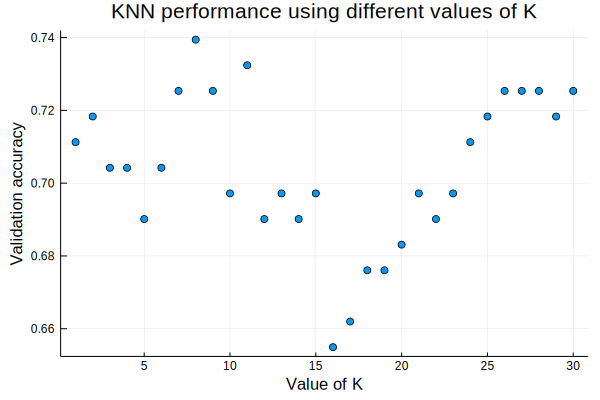

In [29]:
scatter(listk, listvalaccuracy,
    title="KNN performance using different values of K",
    xlabel="Value of K",
    ylabel="Validation accuracy",
    label=""
)